# Problem Set 2

# Constants
Set these to make things run faster. In order to use the maximum of these constants, just set them to `None`.

In [3]:
NUM_CASES = 1000 # Number of cases (spacys tokenization is quite slow)
NUM_FEAT = 1000 # Number of features to use
TEST_RATIO = .1 # Test ratio for Machine Learning tasks

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Load data

In [5]:
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile

def counter_message(cnt, max_cnt, action):
    """Display Progress
    """   
    #Print Message
    print("\r{}/{}: {}.".format(cnt, max_cnt, action), end=" "*10, flush=True)

    
# Load metadata
outcomes = {}
judge_ids = {}
log_cites = {}

metadata = pd.read_csv("data/case_metadata.csv")
metadata = metadata.dropna(axis='index', how='any') # remove rows with missing values

for caseid, outcome, judgeid, year, logcites in metadata.values:
    outcomes[caseid] = outcome
    judge_ids[caseid] = int(judgeid)
    log_cites[caseid] = logcites

    
# Load case data
zfile = ZipFile("data/cases.zip")

caseids = []
raw_texts = {}
years = {}


# Randomly shuffle files and choose as many as we need
files = zfile.namelist()
files = np.random.permutation(files)

if NUM_CASES is None:
    NUM_CASES = len(files)
NUM_CASES = min(NUM_CASES, len(metadata))


cnt = 0
for case in files:
    if cnt >= NUM_CASES:
        break
    year, caseid = case[:-4].split("_")
    if caseid in metadata['caseid'].values:
        cnt += 1
        with zfile.open(case) as f:
            raw_texts[caseid] = f.read().decode()
        years[caseid] = int(year)
        caseids.append(caseid)
        counter_message(cnt, NUM_CASES, "opened")


1000/1000: opened.                                                                                                                                                                                                                                                                                                                                                                                 

Convert to `spacy` documents:

In [7]:
import spacy
nlp = spacy.load('en') # requires:python -m spacy download en

spacy_documents = {}
for cnt, caseid in enumerate(caseids, start=1):
    spacy_documents[caseid] = nlp(raw_texts[caseid])
    counter_message(cnt, NUM_CASES, "converted")
    

1000/1000: converted.          

# Normalize corpus


In [9]:
from nltk import ngrams
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
import string

def normalize(token):
    """Normalize Token. Get Lemma (base form), remove punctuation and stopwords
    """
    lemma = token.lemma_
    nopunct = lemma.translate(str.maketrans('', '', string.punctuation))
    return nopunct

normalized_docs = {}
noun_ngrams = {}
word_counts = {}

# Lemmatize Cases
for cnt, caseid in enumerate(caseids, start=1):
    spacy_document = spacy_documents[caseid]
    normalized_docs[caseid] = []
    tokens = []
    for token in spacy_document:
        if (not token.is_punct) and (not token.is_space) and (token not in stoplist): 
            tokens.append(token)
            norm = normalize(token)
            normalized_docs[caseid].append(norm)
            
            if not norm in word_counts: # We've seen the word for the first time
                word_counts[norm] = 1
            else:                       # We already know this word
                word_counts[norm] += 1
    
    noun_ngram = []
    for ngram in ngrams(tokens, 3): # iterate over all 3-grams
        if ngram[2].pos_ == "NOUN": # check if last word is a noun
            curr_ngram = (normalize(ngram[0]),
                               normalize(ngram[1]),
                               normalize(ngram[2]))
            noun_ngram.append(curr_ngram)   # Stores 3-grams for this case
    
    noun_ngrams[caseid] = noun_ngram
    counter_message(cnt, NUM_CASES, "normalized")


1000/1000: normalized.                                                                                                                                                                                                                                    

# Featurization: 3-grams ending in a noun

In [10]:
from collections import Counter

X = []

# Get most common n_grams
most_common = Counter([ngram for ngrams in noun_ngrams.values() for ngram in ngrams]).most_common(NUM_FEAT)

for cnt, caseid in enumerate(caseids, start=1):
    ngram_cnts = Counter(noun_ngrams[caseid])
    features = np.zeros(len(most_common))
    for i, ngram in enumerate(most_common):
        ngram = ngram[0]
        if ngram in ngram_cnts: #Only add most common 3-gram frequencies
            features[i] = ngram_cnts[ngram]
    X.append(features)
    counter_message(cnt, NUM_CASES, "created ML features")

# convert to numpy array
X = np.array(X)

#standardize; maintain sparsity by not taking out the mean
X = X / np.std(X, axis=0)

#Shuffle Dataset
permutation = np.random.permutation(X.shape[0])
X = X[permutation]

#Split into test & train dataset
test_samples = int(X.shape[0]*TEST_RATIO)

X_test = X[:test_samples]
X_train = X[test_samples:]

1000/1000: created ML features.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

# Train logistic regression model

In [11]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

y = []
for cnt, caseid in enumerate(caseids, start=1):
    y.append(outcomes[caseid])
y = np.array(y)

# Shuffle
y = y[permutation]

# Split
y_test = y[:test_samples]
y_train = y[test_samples:]

# Fit Logistic Regression Model with standard parameters
clf = LogisticRegression().fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print("accuracy: {:.4f}".format(accuracy))
print("f1 score: {:.4f}".format(f1))


accuracy: 0.5200
f1 score: 0.5932


Using Grid search to find optimal parameters

In [12]:
from sklearn.model_selection import GridSearchCV

# Apply Grid Search
parameters = {'penalty':('l1', 'l2'), 'C':[2**e for e in range(-5,2)]}
lreg = LogisticRegression()
clf = GridSearchCV(lreg, parameters, cv=5)
clf.fit(X_train, y_train)

params = clf.best_params_
clf = clf.best_estimator_

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print("Optimal C: {}".format(params['C']))
print("Optimal Penalty: {}".format(params['penalty']))
print("accuracy: {:.4f}".format(accuracy))
print("f1 score: {:.4f}".format(f1))


Optimal C: 0.03125
Optimal Penalty: l1
accuracy: 0.6500
f1 score: 0.7879


# Exercise 1

Use `cross_val_predict()` to form model predictions of whether a case was reversed (`cross_val_predict()` obtains predictions that are trained on data outside that row’s fold). Construct a confusion matrix for the predictions. Report the `precision_recall_curve()` and `roc_curve()`. Make a calibration plot (as in Bansak et al 2018, appendix page 23).

In [68]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LinearRegression, ElasticNet
from linearmodels.iv import IV2SLS
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from numpy.random import randint
from wordcloud import WordCloud
from keras.models import Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout
from keras.regularizers import l2 as l2_reg

# Display plots directly inline
%matplotlib inline

In [69]:
y_pred = cross_val_predict(clf, X_train, y_train, cv=5)
acc = accuracy_score(y_pred, y_train)
f1 = f1_score(y_pred, y_train)

print("accuracy: {:.4f}".format(acc))
print("f1 score: {:.4f}".format(f1))

accuracy: 0.6144
f1 score: 0.7609


In [70]:
print(confusion_matrix(y_train, y_pred))

[[  1 344]
 [  3 552]]


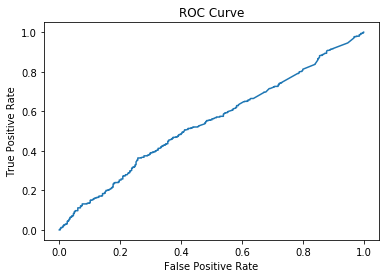

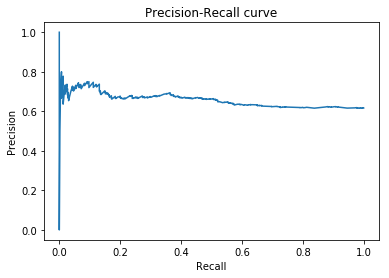

In [71]:
predict_proba = cross_val_predict(clf, X_train, y_train, cv=5, method='predict_proba')
predict_proba = predict_proba[:,1]
fpr, tpr, _ = roc_curve(y_train, predict_proba)
                          
precision, recall, _ = precision_recall_curve(y_train, predict_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

plt.figure()
plt.plot(recall, precision)
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

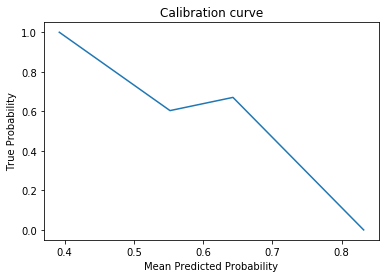

In [72]:
prob_true, prob_pred = calibration_curve(y_train, predict_proba, n_bins=5)

plt.plot(prob_pred, prob_true)
plt.title('Calibration curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.show()

# Exercise 2

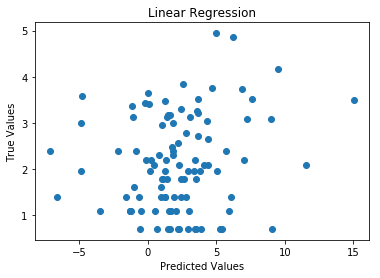

In [73]:
y = np.array([log_cites[caseId] for caseId in caseids])
y = y[permutation]
y_train, y_test = y[test_samples:], y[:test_samples]

lr = LinearRegression().fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure()
plt.scatter(y_pred, y_test)
plt.title('Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

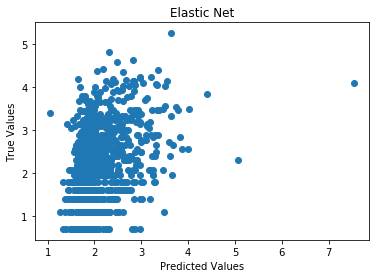

In [74]:
enet = ElasticNet(alpha=0.05)
y_pred = cross_val_predict(enet, X_train, y_train, cv=5)

plt.figure()
plt.scatter(y_pred, y_train)
plt.title('Elastic Net')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

# Exercise 4

In [75]:
dictionary = corpora.Dictionary(normalized_docs.values())

dictionary.filter_extremes(no_below=3, no_above=0.5, keep_n=100000)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in normalized_docs.values()]

lda = LdaModel(doc_term_matrix, num_topics=10, id2word = dictionary, passes=5)
lda.show_topics(formatted=False)

[(0,
  [('government', 0.005011259),
   ('congress', 0.004741443),
   ('tax', 0.003755927),
   ('patent', 0.0036328558),
   ('plaintiff', 0.003593982),
   ('loss', 0.0033549904),
   ('', 0.0032879899),
   ('land', 0.0029260598),
   ('product', 0.0027042737),
   ('amendment', 0.0026739838)]),
 (1,
  [('union', 0.0062512797),
   ('employee', 0.004923195),
   ('board', 0.0048900363),
   ('labor', 0.004170694),
   ('government', 0.0039448556),
   ('appellant', 0.0038587917),
   ('plaintiff', 0.0029749728),
   ('employer', 0.002562208),
   ('statement', 0.002485994),
   ('motion', 0.0024540292)]),
 (2,
  [('commission', 0.0087415585),
   ('price', 0.008384482),
   ('market', 0.0061167185),
   ('pie', 0.0055533512),
   ('', 0.004144012),
   ('sale', 0.0038927332),
   ('plaintiff', 0.0037676406),
   ('company', 0.003680638),
   ('cost', 0.0035165644),
   ('sell', 0.003376962)]),
 (3,
  [('plan', 0.00712457),
   ('plaintiff', 0.004135042),
   ('benefit', 0.0041076085),
   ('process', 0.0038269

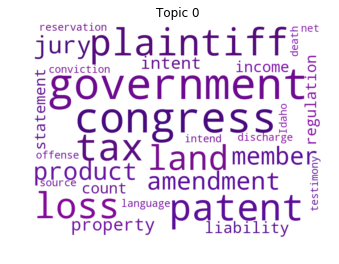

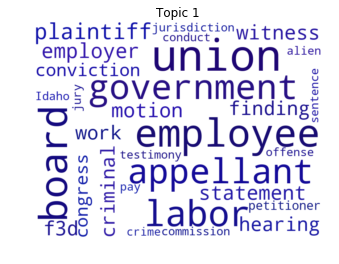

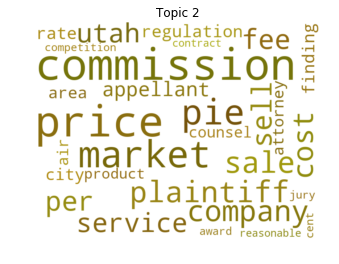

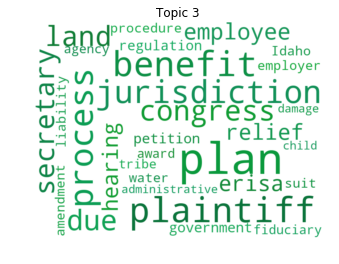

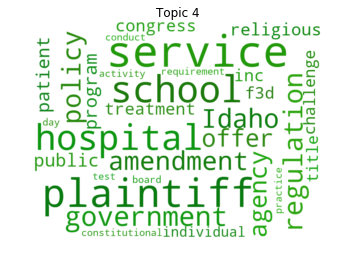

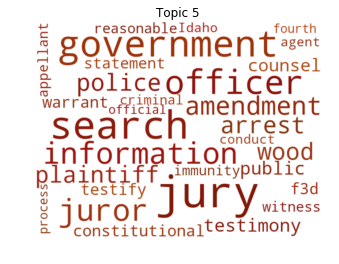

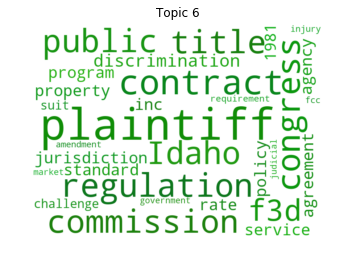

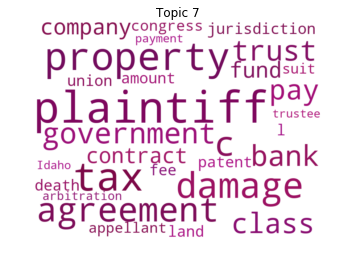

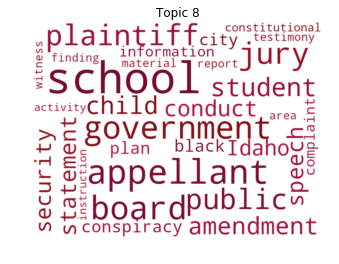

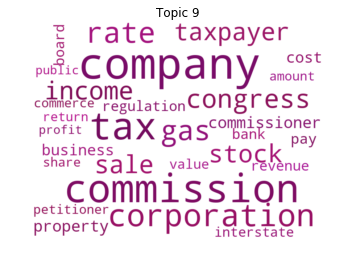

In [76]:
for i,weights in lda.show_topics(num_topics=-1, num_words=30, formatted=False):
    maincol = randint(0,360)
    def colorfunc(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):   
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)   

    
    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic {}".format(i))
    plt.show()
    


# Exercise 5

In [77]:
y = np.array([outcomes[caseId] for caseId in caseids])
y = y[permutation]
y_train, y_test = y[test_samples:], y[:test_samples]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1)                 1001      
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________
Train on 900 samples, validate on 100 samples
Epoch 1/20
900/900 [==============================] - 1s 744us/step - loss: 0.8699 - acc: 0.5167 - val_loss: 0.8518 - val_acc: 0.5300
Epoch 2/20
900/900 [==============================] - 0s 39us/step - loss: 0.7668 - acc: 0.5789 - val_loss: 0.8478 - val_acc: 0.5300
Epoch 3/20
900/900 [==============================] - 0s 45us/step - loss: 0.6995 - acc: 0.6200 - val_loss: 0.8488 - val_acc: 0.5000
Epoch 4/20
900/900 [==============================] - 0s 42us/step - loss: 0.6442 - acc: 0.6556 - val_loss: 0.8392 - val_acc: 0.5100
Epoch 5/20
900/900 [==============================] - 0s 41us/step - loss: 0.5996 - acc: 

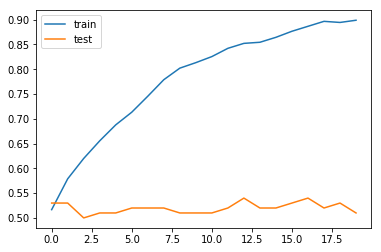

In [78]:
# Logistic Regression with L2 Penalty

model = Sequential() 
model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid', kernel_regularizer=l2_reg(0.01))) # best was L1 before
model.summary()

# fit on train
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_info = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

plt.plot(model_info.epoch, model_info.history['acc'])
plt.plot(model_info.epoch, model_info.history['val_acc'])
plt.legend(['train', 'test'], loc='best')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 250)               250250    
_________________________________________________________________
batch_normalization_7 (Batch (None, 250)               1000      
_________________________________________________________________
activation_7 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                12550     
_________________________________________________________________
batch_normalization_8 (Batch (None, 50)                200       
_________________________________________________________________
activation_8 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

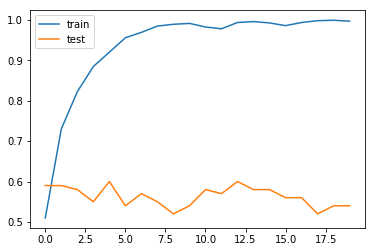

In [79]:
# 2 hidden layers network

model = Sequential()
model.add(Dense(250, input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_info = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

plt.plot(model_info.epoch, model_info.history['acc'])
plt.plot(model_info.epoch, model_info.history['val_acc'])
plt.legend(['train', 'test'], loc='best')

